In [46]:
import sys
import os
import yaml
import numpy as np
#import pandas
from io import StringIO
import pandas as pd
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [2]:
# Get paths from configuration file
case = 'main'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# loading_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting")
#runs = [*ssm['paths']['nutrient_loading_inputs']]
# loading_files = {}
# ssm['paths']['nutrient_loading_inputs']['3j']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3j/coldstart/inputs/ssm_pnt_wq.dat'
# ssm['paths']['nutrient_loading_inputs']['3k']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3k/coldstart/inputs/ssm_pnt_wq.dat'
# ssm['paths']['nutrient_loading_inputs']={}
# ssm['paths']['nutrient_loading_inputs']['4b']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4b/coldstart/inputs/ssm_pnt_wq.dat'
# ssm['paths']['nutrient_loading_inputs']['4c']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4c/coldstart/inputs/ssm_pnt_wq.dat'
runs = [*ssm['paths']['nutrient_loading_inputs']]
for run in runs:
    print(ssm['paths']['nutrient_loading_inputs'][run])

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4b/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4c/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4c.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4d.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4e.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4f.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4g.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4h.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4i.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4j.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4k/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_

In [3]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets')
source_locations = pd.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
source_names=source_locations.index.tolist()

In [4]:
inputs = {}
for run in runs:
    print(ssm['paths']['nutrient_loading_inputs'][run])
    with open(ssm['paths']['nutrient_loading_inputs'][run]) as f:
        # The parsing logic here is is derived from the linkage instructions for the
        # model and direct examination of the source code

        # The first line does not contain important information and is treated only like
        # a filetype magic
        next(f)

        # The total number of discharge nodes
        num_qs = int(next(f))
        # All the node numbers with discharges
        #nodes = np.loadtxt([next(f) for l in range(num_qs)], comments='!', dtype=int)
        node_raw = StringIO('\n'.join([next(f) for l in range(num_qs)]))
        node_df = pd.read_csv(node_raw, sep='\s+!\s+', names=('Node','Comment'),
                              dtype={'Node':np.int64,'Comment':object}, engine='python')
        node_df.set_index('Node', inplace=True)
        nodes = node_df.index.to_numpy()
        # Depth distribution fractions into each node. Skipping the first (node count) column
        vqdist = np.loadtxt([next(f) for l in range(num_qs)])[:,1:]

        num_times = int(next(f))

        # Initialize storage arrays
        times = np.zeros(num_times)
        qs = np.zeros((num_times, num_qs))
        # State variables in the order they are present in the file. These are also going
        # to be the NetCDF variable names
        statevars = ('discharge', 'temp', 'salt', 'tss',  'alg1', 'alg2', 'alg3', 'zoo1',
                                  'zoo2', 'ldoc', 'rdoc', 'lpoc', 'rpoc', 'nh4',  'no32',
                                  'urea', 'ldon', 'rdon', 'lpon', 'rpon', 'po4',  'ldop',
                                  'rdop', 'lpop', 'rpop', 'pip',  'cod',  'doxg', 'psi',
                                  'dsi',  'alg1p','alg2p','alg3p','dic',  'talk')
        inputs[run] = {}
        for v in statevars:
            inputs[run][v] = np.zeros((num_times, num_qs))

        for t in range(num_times):
            times[t] = float(next(f))
            for v in statevars:
                inputs[run][v][t,:] = np.loadtxt([next(f)])

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4b/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4c/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4c.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4d.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4e.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4f.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4g.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4h.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4i.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_pnt_wq_4j.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4k/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/4x_inputs/ssm_

In [5]:
total_nitrogen={}
total_annual_nitrogen={}
loading={}
for run in runs:
    loading[run] = (inputs[run]['discharge'] * (inputs[run]['nh4'] + inputs[run]['no32']) * 24 * 3600)/1000 #m3/s*mg/l -> kg/day
    total_nitrogen[run]=loading[run].sum(axis=0) # annual loading over 366 days (g/year)
    total_annual_nitrogen[run] = total_nitrogen[run].sum() # g/year -> kg/year

In [8]:
inputs[run]['discharge'].shape

(366, 259)

In [ ]:
# print information to excel
# one tab for each run

### Print source_names to get the right text names

In [10]:
locations = ['  Brightwater', '  South King', '  West Point']

### Loop through locations and print indices for above WWTPs

In [11]:
print('idices: ', [source_names.index(locations[idx]) for idx in [0,1,2]])

idices:  [183, 195, 197]


In [12]:
wwtp_indices = [source_names.index(locations[idx]) for idx in [0,1,2]]
wwtp_indices

[183, 195, 197]

# plot concentrations

14.667897663934431
12.386877595628416
11.418962295081968
2.9999629644808743
3.000056229508197
22.47055464480874
26.15902732240437
21.452359289617487
22.498310928961747
30.746174863387985
25.209836065573768
13.301968579234973
30.746174863387985
25.209836065573768
0.1609590163934426
30.746174863387985
12.687859289617485
26.438005464480874
30.746174863387985
0.16095628415300545
26.438005464480874
15.453005464480874
25.209836065573768
26.438005464480874
0.1609590163934426
25.209836065573768
26.438005464480874


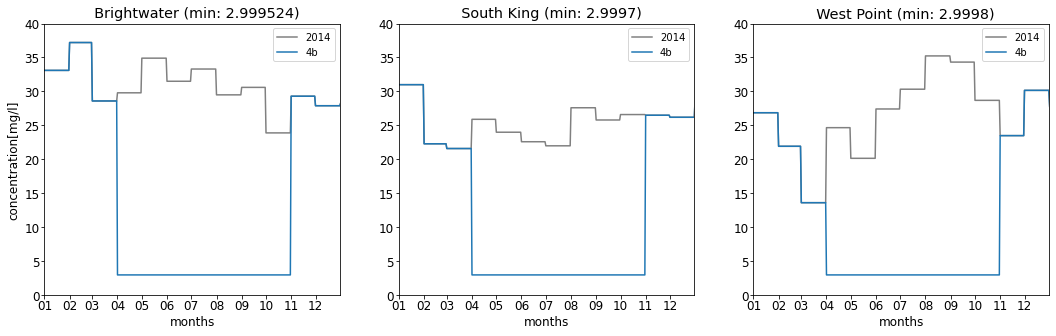

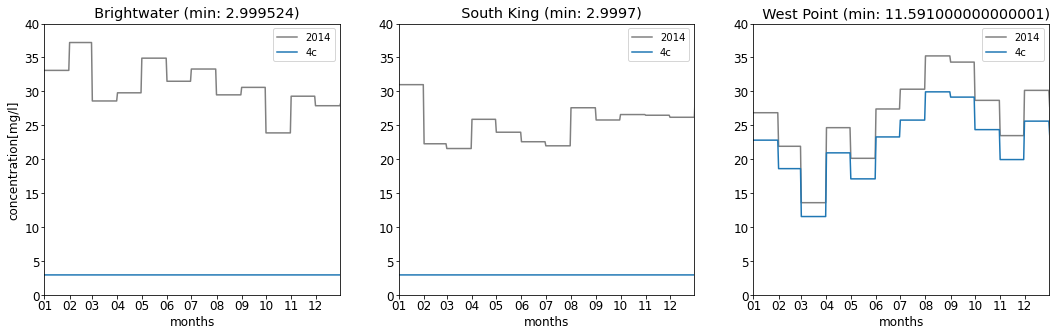

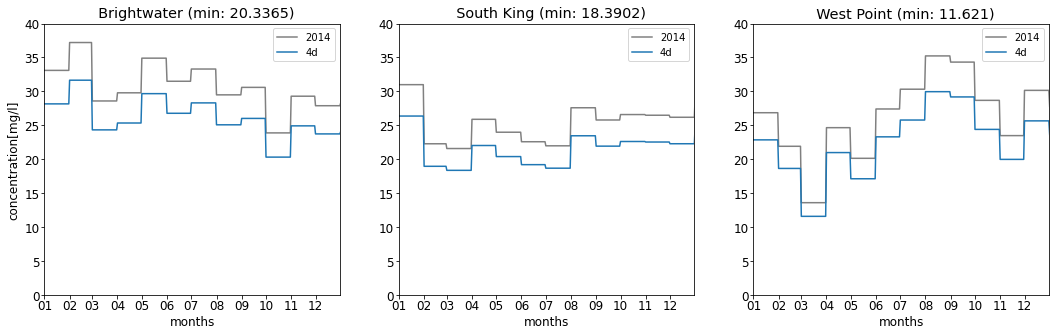

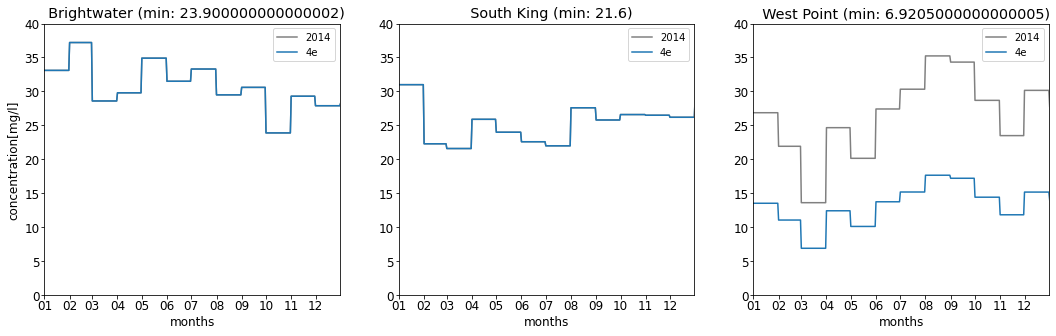

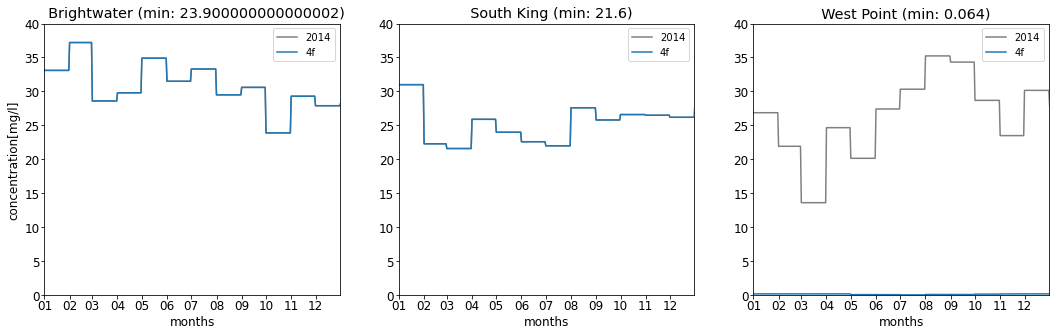

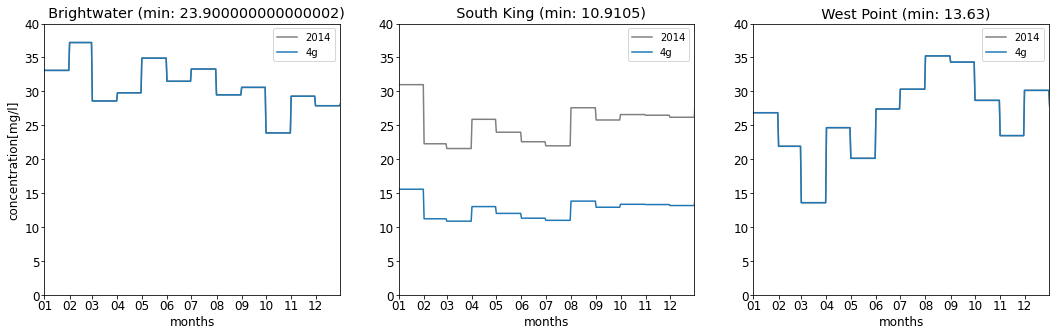

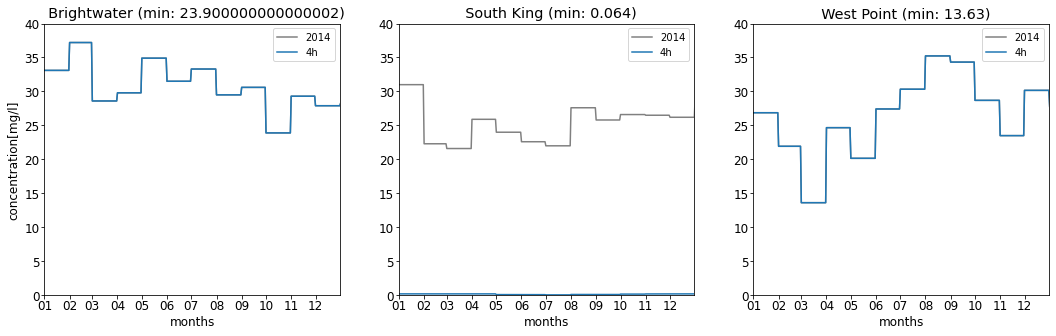

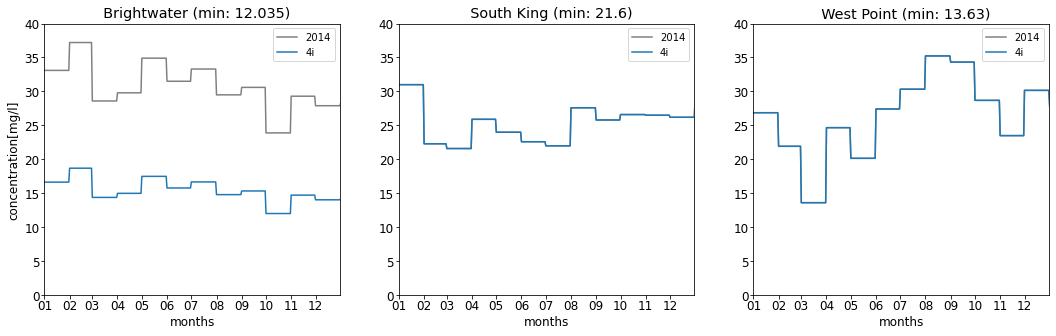

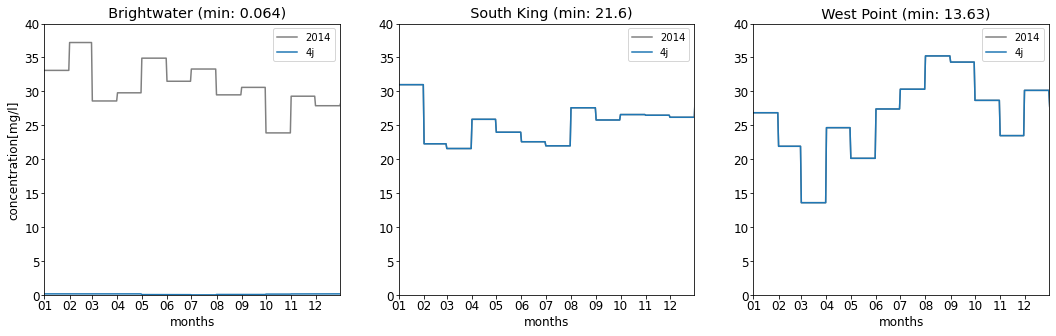

In [43]:
for run_id in ["4b", "4c", "4d","4e","4f","4g","4h","4i","4j"]:
    # create date vector
    dti = pd.date_range("2014-01-01", periods=366, freq="d")
    dti[-1]
    mpl.rc('font', size = 12, family='sans-serif', weight='normal', style='normal')
    fig,ax=plt.subplots(1,3, figsize=(18,5),
       gridspec_kw={
       'width_ratios': [1,1,1],
       'height_ratios': [1], 
       'wspace': 0.2,
       'hspace': 0.5}
    )
    for idx in [0,1,2]:
        baseline_concentration = inputs["wqm_baseline"]['nh4'][:,[source_names.index(locations[idx])]] + inputs["wqm_baseline"]['no32'][:,[source_names.index(locations[idx])]]
        run_concentration = inputs[run_id]['nh4'][:,[source_names.index(locations[idx])]] + inputs[run_id]['no32'][:,[source_names.index(locations[idx])]]
        ax[idx].plot(dti,baseline_concentration, color='grey', label="2014")
        ax[idx].plot(dti,run_concentration, label=run_id)
        print(run_concentration.mean())
        ax[idx].set_title(f'{locations[idx]} (min: {np.min(run_concentration)})')
        ax[idx].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
        # set x-ticklabels to the first day of the month
        ax[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
        ax[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
        ax[idx].set_ylim(0,40)
    # take the difference of Everett Snohomish and add it to OF100
    delta_north = loading["wqm_baseline"][:,[source_names.index(locations[0])]]-loading[run_id][:,[source_names.index(locations[0])]]
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_xlabel('months')
    ax[1].set_xlabel('months')
    ax[2].set_xlabel('months')
    ax[0].set_ylabel('concentration[mg/l]')
    plt.savefig(pathlib.Path(ssm['paths']['graphics'])/f'ssm_pnt_wq_{run_id}_concentrations.png')

In [44]:
ssm['paths']['graphics']

'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/'

# plot discharge

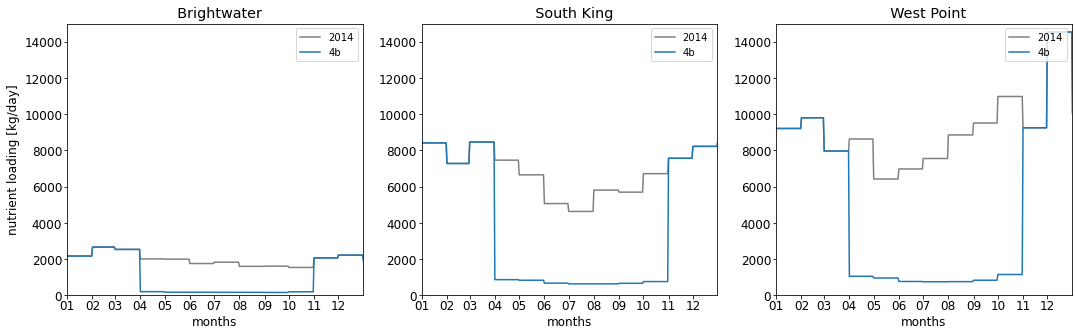

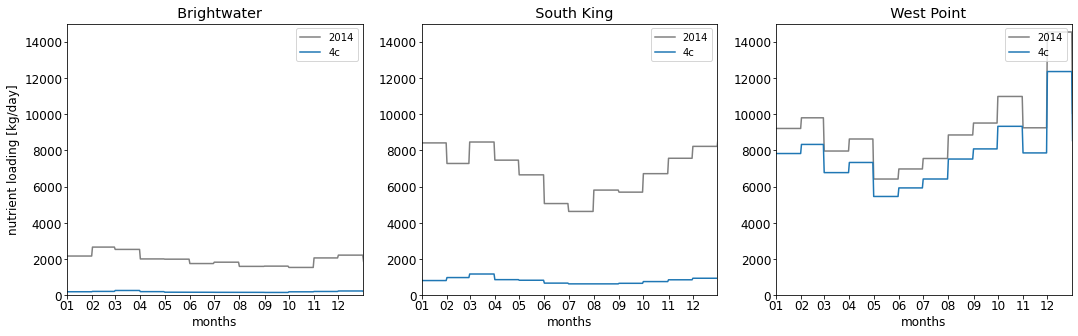

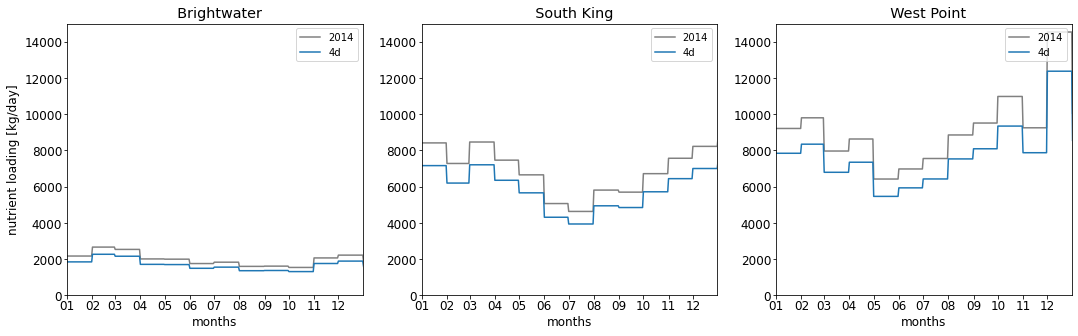

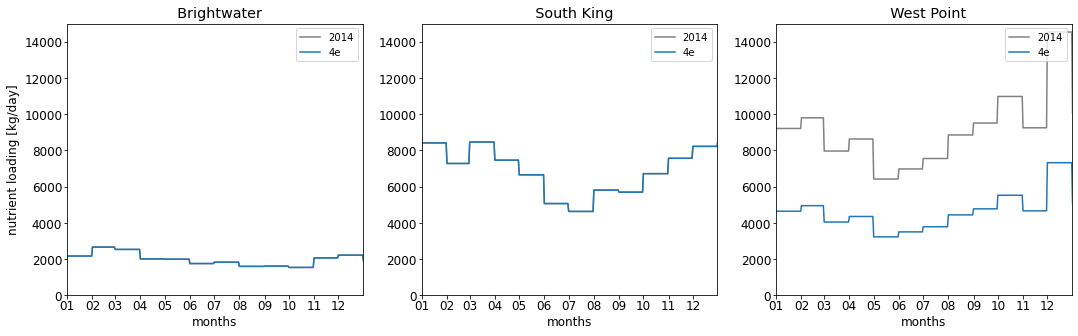

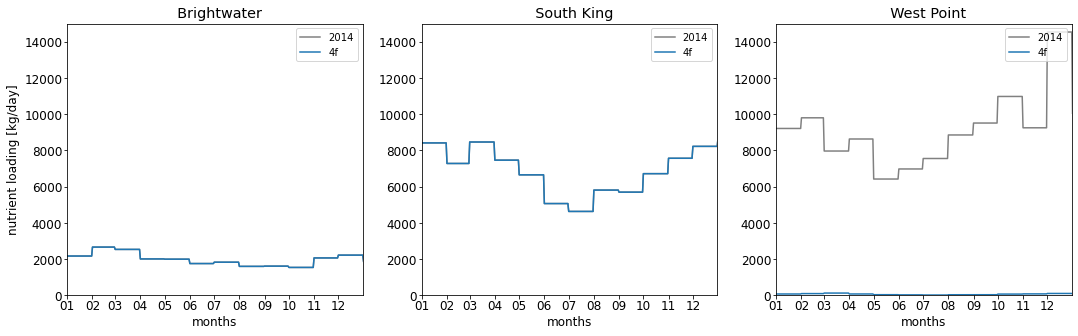

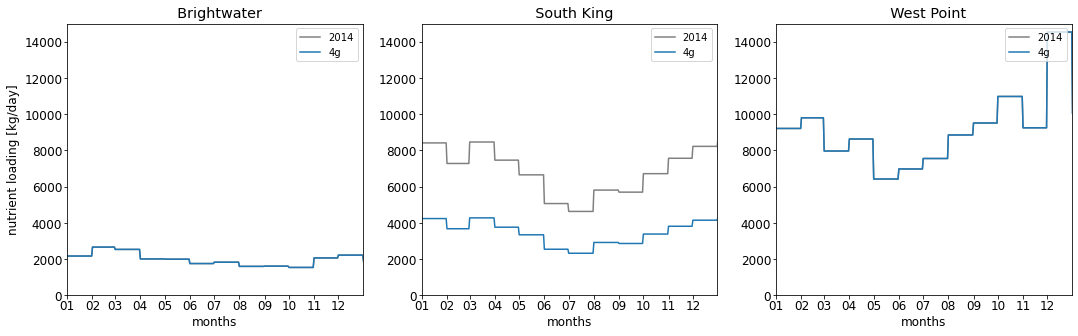

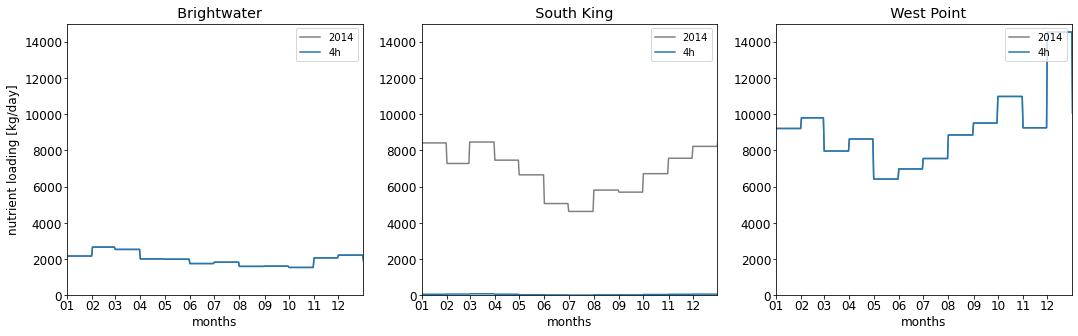

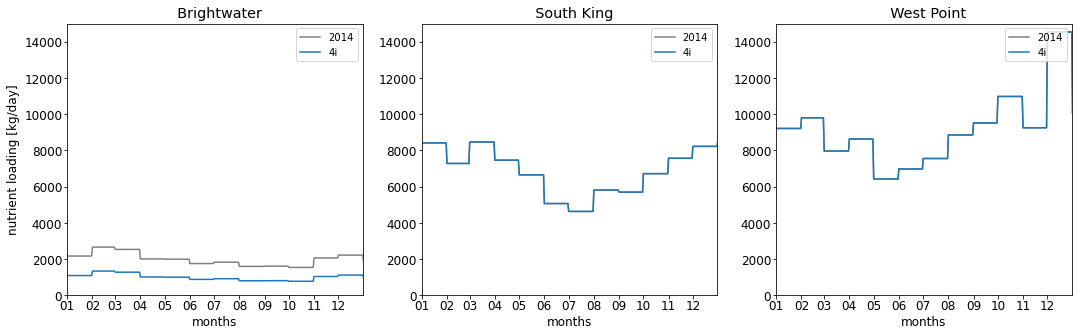

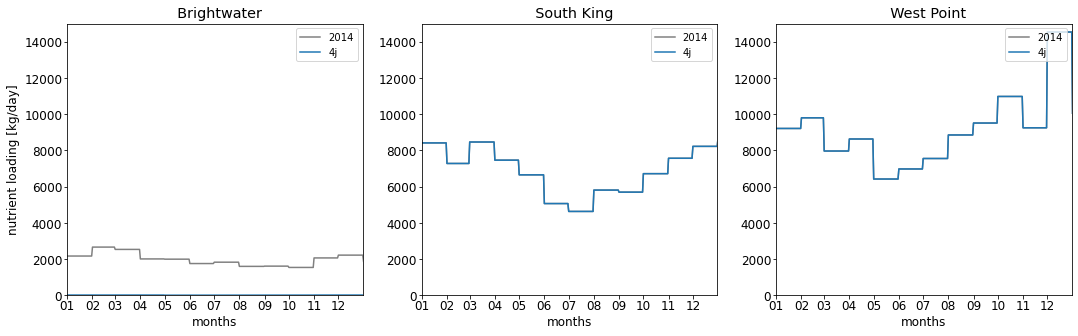

In [47]:
for run_id in ["4b", "4c", "4d","4e","4f","4g","4h","4i","4j"]:
    # create date vector
    dti = pd.date_range("2014-01-01", periods=366, freq="d")
    dti[-1]
    mpl.rc('font', size = 12, family='sans-serif', weight='normal', style='normal')
    fig,ax=plt.subplots(1,3, figsize=(18,5),
       gridspec_kw={
       'width_ratios': [1,1,1],
       'height_ratios': [1], 
       'wspace': 0.2,
       'hspace': 0.5}
    )
    for idx in [0,1,2]:
        ax[idx].plot(dti,loading["wqm_baseline"][:,[source_names.index(locations[idx])]], color='grey', label="2014")
        ax[idx].plot(dti,loading[run_id][:,[source_names.index(locations[idx])]], label=run_id)
        # if (idx == 0) or (idx == 1):
        #     ax[idx].plot(dti,loading["4csk"][:,[source_names.index(locations[idx])]], label="4cSK")
        # if run_id == "4c":
        #     ax[idx].plot(dti,loading["4csk"][:,[source_names.index(locations[idx])]], label="4cSK", color="green")
        ax[idx].set_title(locations[idx])
        ax[idx].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
        # set x-ticklabels to the first day of the month
        ax[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
        ax[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
        ax[idx].set_ylim(0,15000)
    # take the difference of Everett Snohomish and add it to OF100
    delta_north = loading["wqm_baseline"][:,[source_names.index(locations[0])]]-loading[run_id][:,[source_names.index(locations[0])]]
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_xlabel('months')
    ax[1].set_xlabel('months')
    ax[2].set_xlabel('months')
    ax[0].set_ylabel('nutrient loading [kg/day]')
    plt.savefig(pathlib.Path(ssm['paths']['graphics'])/f'ssm_pnt_wq_{run_id}_loadings.png',
                            bbox_inches='tight',format='png')


In [31]:
scenario_setting=pd.read_excel(in_dir/'run_strategy.xlsx',index_col=0,sheet_name='3j')

In [6]:
scenario_setting.sum()

Unnamed: 1                         Agate East  Agate West  Anderson east  Ander...
type                             RiverRiverRiverRiverRiverRiverRiverRiverRiverR...
node_id                                                                    2901526
Lat                                                                   12370.385375
Lon                                                                   -31802.22129
Depth [km]                                                                9.989324
layer_distribute                 Surface3Surface3Surface3Surface3Surface3Surfac...
Region                             South_Sound  South_Sound  South_Sound  South...
country                            United States  United States  United States ...
NH4[kg/year]                                                       25354056.180308
NO3NO2[kg/year]                                                    26759513.324702
N-load [kg/year] (Baseline)                                        52113569.508102
N-lo

In [32]:
scenario_setting_orig=pd.read_excel(in_dir/'run_strategy.xlsx',index_col=0)
scenario_setting_orig.sum()

Unnamed: 1                         Agate East  Agate West  Anderson east  Ander...
type                             RiverRiverRiverRiverRiverRiverRiverRiverRiverR...
node_id                                                                    2901526
Lat                                                                   12370.385375
Lon                                                                   -31802.22129
Depth [km]                                                                9.989324
layer_distribute                 Surface3Surface3Surface3Surface3Surface3Surfac...
Region                             South_Sound  South_Sound  South_Sound  South...
country                            United States  United States  United States ...
NH4[kg/year]                                                       25014665.038308
NO3NO2[kg/year]                                                    26734305.911622
N-load [kg/year] (Baseline)                                        51748970.953002
N-lo

In [14]:
scenario_setting.loc[scenario_setting['Unnamed: 1']=='  Everett Snohomish']

,Unnamed: 1,type,node_id,Lat,Lon,Depth [km],layer_distribute,Region,country,NH4[kg/year],...,N-load % Difference,Anthropogenic.1,flow_yearly_sum [m3],flow_yearly_mean [m3],NO3NO2-yearly_avg_conc [mg/L],NH4-yearly_avg_conc [mg/L],Average Annual TIN (mg/L),calculated yearly N-loading,percent loading diff,3j
201,Everett Snohomish,Point Source,12179,48.004747,-122.1769,0.00592,Layer 10,Whidbey,United States,339391.142,...,-1.0,NaN,188.1732,0.514134,2.244,20.432,22.676,367662.47,0.01,0
